In [5]:
from BaconShor3CXheavyhex import BS3CXheavyhex
from utils import build_stim_circuit
import numpy as np
import stim

def onlyBS(d, T,logical_prep, offset = -2+6j,
            num_qubits = -1, 
            virt_link = False,
            CXerror= 0, Rerror= 0, singleQerror=0):
    """We still do measurements on the other sublattice, but there are no additional CX layers from the 3CX code"""
    
    code = BS3CXheavyhex(d=d, T=T, logical_prep=['Z',logical_prep], logical_meas=['Z',logical_prep], offset=offset,
                            num_qubits=num_qubits, 
                            virt_link=virt_link,
                            CX_schedule = ['BSZ0', 'BSZ1','BSX1', 'BSX0'],
                            CXerror=CXerror, Rerror=Rerror,singleQerror=singleQerror)
    return code

In [37]:
# def sample_from_histogram(data, bins, n_samples, seed=42):
#     count, bin_edges = np.histogram(data, bins=bins)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     pmf = count / np.sum(count)
#     cdf = np.cumsum(pmf)

#     np.random.seed(seed)
#     random_numbers = np.random.rand(n_samples)
#     sampled_indices = np.searchsorted(cdf, random_numbers)

#     return bin_centers[sampled_indices]

# def adjust_samples_to_match_mean_variance(samples, original_mean, original_variance, multiplicative_factor = 1):
#     # Calculate current mean and std deviation of the samples
#     samples_mean = np.mean(samples)
#     samples_std = np.std(samples)
    
#     # Calculate target std deviation from the target variance
#     target_std = np.sqrt(original_variance)
    
#     # Adjust samples
#     # if multiplicative_factor < 1:
#     #     adjusted_samples = ((samples - samples_mean) / samples_std) * target_std * multiplicative_factor + original_mean * multiplicative_factor
#     #     # Leave target_std as is 
#     # if multiplicative_factor > 1:
#     #     diff_mean = original_mean * multiplicative_factor - samples_mean
#     #     adjusted_samples = samples + diff_mean

#     adjusted_samples = ((samples - samples_mean) / samples_std) * target_std * multiplicative_factor + original_mean * multiplicative_factor

#     offset = 1e-4
#     mask_below = adjusted_samples < 0
#     mask_above = adjusted_samples > 0.5
#     random_offsets_below = np.random.uniform(0, offset, mask_below.sum())
#     random_offsets_above = np.random.uniform(0, -offset, mask_above.sum())

#     adjusted_samples_clipped = adjusted_samples.copy()
#     adjusted_samples_clipped[mask_below] = 0 + random_offsets_below
#     adjusted_samples_clipped[mask_above] = 0.5 + random_offsets_above
    
#     return adjusted_samples_clipped


# def sample_from_histogram_and_adjust(data, bins, n_samples, multiplicative_factor = 1, seed=42):
#     count, bin_edges = np.histogram(data, bins=bins)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     pmf = count / np.sum(count)
#     cdf = np.cumsum(pmf)
    
#     np.random.seed(seed)
#     random_numbers = np.random.rand(n_samples)
#     sampled_indices = np.searchsorted(cdf, random_numbers)
#     sampled_data = bin_centers[sampled_indices]
    
#     # Adjust the sampled data to match the mean and variance of the original data
#     original_mean = np.mean(data) 
#     original_variance = np.var(data) 
#     adjusted_samples = adjust_samples_to_match_mean_variance(sampled_data, original_mean, original_variance, multiplicative_factor)
    
#     return adjusted_samples


In [38]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm

def sample_from_histogram(data, bins, n_samples, seed=42):
    np.random.seed(seed)
    count, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pmf = count / np.sum(count)
    cdf = np.cumsum(pmf)
    random_numbers = np.random.rand(n_samples)
    sampled_indices = np.searchsorted(cdf, random_numbers)
    return bin_centers[sampled_indices]

def generate_means_factors(data, bins, n_samples, factors, seed=42):
    means = []
    for mult_factor in factors:
        sampled_data = sample_from_histogram(data, bins, n_samples, seed=seed)
        adjusted_samples = adjust_samples_to_match_mean_variance(
            sampled_data, np.mean(data), np.var(data), mult_factor)
        means.append(np.mean(adjusted_samples))
    return means, factors

def adjust_samples_to_match_mean_variance(samples, og_mean, og_variance, factor):
    samples_mean = np.mean(samples)
    samples_std = np.std(samples)
    og_std = np.sqrt(og_variance)
    adjusted_samples = ((samples - samples_mean) / samples_std) * og_std * factor + og_mean * factor
    adjusted_samples = np.clip(adjusted_samples, 0, 0.5)  # Ensuring values stay within 0 and 0.5
    return adjusted_samples

def find_multiplicative_factor_for_mean(target_mean, means, factors):
    means, factors = zip(*sorted(zip(means, factors)))
    interp = interp1d(means, factors, kind='linear', fill_value="extrapolate")
    return interp(target_mean)

def sample_from_histogram_and_adjust(data, bins, n_samples, needed_factor=1, seed=42):
    np.random.seed(seed)
    to_be_tested_factors = np.linspace(0.001, 20, 20)
    means, factors = generate_means_factors(data, bins, n_samples, to_be_tested_factors, seed=seed)
    sampled_data = sample_from_histogram(data, bins, n_samples, seed=seed)
    factor = find_multiplicative_factor_for_mean(np.mean(data) * needed_factor, means, factors)
    adjusted_samples = adjust_samples_to_match_mean_variance(sampled_data, np.mean(data), np.var(data), factor)
    return adjusted_samples


In [14]:
def soften_circuit(stim_circuit, arg_list):
    sample_idx = 0
    soft_stim_circuit = stim.Circuit()
    try:
        for instr in stim_circuit:
            if instr.name == 'PAULI_CHANNEL_1':
                if instr.gate_args_copy()[1] == 0 and instr.gate_args_copy()[2] == 0: # weird after H msmts error 
                    for target in instr.targets_copy():
                        arg_el = arg_list[sample_idx]
                        sample_idx += 1
                        arg = instr.gate_args_copy()[0] + arg_el - 2*instr.gate_args_copy()[0]*arg_el
                        soft_stim_circuit.append(instr.name, [target], [arg, 0, 0])
            elif instr.name == 'M':
                for target in instr.targets_copy():
                    arg_el = arg_list[sample_idx]
                    sample_idx += 1
                    soft_stim_circuit.append(instr.name, [target], [arg_el])
            else:
                soft_stim_circuit.append(instr.name, instr.targets_copy(), instr.gate_args_copy())
    except IndexError:
        print('Not enough samples for softening')


    return soft_stim_circuit


def get_nb_args(stim_circuit):
    num_args = 0
    for instr in stim_circuit:
        if instr.name == 'PAULI_CHANNEL_1':
            if instr.gate_args_copy()[1] == 0 and instr.gate_args_copy()[2] == 0: # weird after H msmts error 
                num_args += len(instr.targets_copy())
        if instr.name == 'M':
            num_args += len(instr.targets_copy())

    return num_args

# Get calib data

In [8]:
import pickle

with open('pSoft.pkl', 'rb') as f:
    pSoft = pickle.load(f)

print(pSoft.shape)

with open('msmt_err_dict.pkl', 'rb') as f:
    msmt_err_dict = pickle.load(f)

p_soft_mean = np.mean([v['p_soft'] for v in msmt_err_dict.values()])
p_hard_mean = np.mean([v['p_hard'] for v in msmt_err_dict.values()])
print(f"p_soft_mean = {p_soft_mean}")
print(f"p_hard_mean = {p_hard_mean}")

(7899014,)
p_soft_mean = 0.008506336000272011
p_hard_mean = 0.025168494155519146


In [9]:
print(f"mean p_soft = {np.mean(pSoft)}")
print(f"std p_soft = {np.std(pSoft)}")

mean p_soft = 0.008480371620016403
std p_soft = 0.045777693104604694


In [76]:
import surface_code_decoder_v2

dist_list = list(range(3,11,2))
error_list = 1*np.logspace(-3,-1,10)
max_shots = 1_000_000
shot_batch = 10_000
max_num_fail = 1_000
log_prep = 'Z'

PS = False

Log_fail_d_p_soft = []
for d in dist_list:
    T=d
    Log_fail_p =[]
    for error in error_list:

        # Get ratios
        pHrat = p_hard_mean / (p_soft_mean + p_hard_mean)
        pSrat = p_soft_mean / (p_soft_mean + p_hard_mean)

        pHrat = 0
        pSrat = 1
        print(f"pHrat = {pHrat}, pSrat = {pSrat}")

        pH = pHrat * error
        pSmean = pSrat * error 
        mult_factor = pSmean/p_soft_mean 

        # Get the code      
        code = onlyBS(d=d, T=T, logical_prep=log_prep,
                    CXerror=error/100, Rerror=error, singleQerror=error/100)
        stim_circuit,relevant_nodes = build_stim_circuit(code, return_relevant_nodes=True)
        
        # num_needed_args = get_nb_args(stim_circuit)
        # arg_list = sample_from_histogram_and_adjust(pSoft, bins=200, n_samples=num_needed_args, needed_factor=mult_factor, seed=42)
        # print(f"needed mean = {pSmean}, actual mean = {np.mean(arg_list)}, actual std = {np.std(arg_list)}")
        
        # soft_circuit = soften_circuit(stim_circuit, arg_list)

        soft_circuit = stim_circuit

        stim_DEM_soft = soft_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
        if PS:
            matching0 = surface_code_decoder_v2.DEM_to_postsel_matching(model=stim_DEM_soft,relevant_nodes=relevant_nodes)
        else:
            matching0 = surface_code_decoder_v2.DEM_to_matching(model=stim_DEM_soft,relevant_nodes=relevant_nodes)
        num_obs = 1

        num_fail = np.array([0]*num_obs)
        num_shots = 0
        num_shots2 = 0
        while num_shots<max_shots and min(num_fail)<max_num_fail:
            num_shots += shot_batch
            detector_samples = soft_circuit.compile_detector_sampler().sample(shot_batch, append_observables=True)
            correction_batch = matching0.decode_batch(detector_samples)
            num_shots2+=len(correction_batch)
            num_fail+=sum(correction_batch)

        print(d,error,min(num_fail)/num_shots2,'+/-',np.sqrt(min(num_fail))/num_shots2, num_shots2/num_shots)

        Log_fail_p.append([error,min(num_fail)/num_shots2,np.sqrt(min(num_fail))/num_shots2])

    Log_fail_d_p_soft.append([d,Log_fail_p])

pHrat = 0, pSrat = 1
3 0.001 2.5e-05 +/- 5e-06 1.0
pHrat = 0, pSrat = 1
3 0.0016681005372000592 8.8e-05 +/- 9.38083151964686e-06 1.0
pHrat = 0, pSrat = 1
3 0.0027825594022071257 0.000236 +/- 1.5362291495737216e-05 1.0
pHrat = 0, pSrat = 1
3 0.004641588833612777 0.000667 +/- 2.5826343140289915e-05 1.0
pHrat = 0, pSrat = 1
3 0.007742636826811269 0.00184 +/- 5.7839904438497694e-05 1.0
pHrat = 0, pSrat = 1
3 0.01291549665014884 0.004885714285714286 +/- 0.000152529689314733 1.0
pHrat = 0, pSrat = 1
3 0.021544346900318832 0.01295 +/- 0.00040233692348577704 1.0
pHrat = 0, pSrat = 1
3 0.03593813663804626 0.03325 +/- 0.0009117291264405235 1.0
pHrat = 0, pSrat = 1
3 0.05994842503189409 0.08035 +/- 0.0020043702252827444 1.0
pHrat = 0, pSrat = 1
3 0.1 0.1657 +/- 0.004070626487409524 1.0
pHrat = 0, pSrat = 1
5 0.001 1e-06 +/- 1e-06 1.0
pHrat = 0, pSrat = 1
5 0.0016681005372000592 8e-06 +/- 2.8284271247461903e-06 1.0
pHrat = 0, pSrat = 1
5 0.0027825594022071257 3.9e-05 +/- 6.244997998398399e-06 1.0


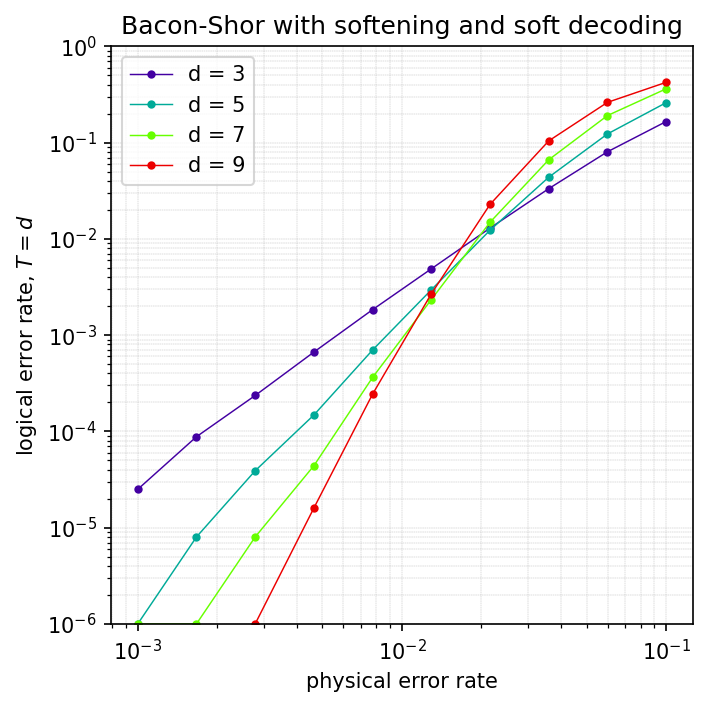

In [77]:
from matplotlib import colormaps
import matplotlib.pyplot as plt

color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/len(dist_list)) for i in range(len(dist_list))]


fig=plt.figure(figsize=(5, 5), dpi=150)

for di,d in enumerate(dist_list):
    phys_err, log_err, _ = np.transpose(Log_fail_d_p_soft[di][1])
    plt.plot(phys_err, log_err,'.-', c=color_list[di],linewidth = 0.7, label = 'd = '+str(d))



pth,pLatth = 1e-3, 0.0025
# pth, pLatth = 8e-4, 0.0015

# for di,d in enumerate(dist_list):
#     phys_err, log_err, log_err_err = np.transpose(Log_fail_d_p[di][1])
#     log_err_err = np.array(log_err_err, dtype=float)
#     log_err = np.array(log_err, dtype=float)
#     phys_err = np.array(phys_err, dtype=float)
#     plt.fill_between(phys_err, log_err-log_err_err, log_err+log_err_err,alpha = 0.13,color=color_list[di]) 
#     plt.plot(error_list, pLatth*(error_list/pth)**np.ceil((d+1)/2),'--',c='gray', alpha=0.5)

# plt.axvline(pth,linestyle=':',c="gray", alpha=0.3, label = f'$p_th = {pth:.1e}$')
# plt.legend(['d = '+str(d) for d in dist_list])
plt.legend()

plt.title(f"Bacon-Shor with softening and soft decoding")
plt.xlabel(r'physical error rate')
plt.ylabel(r'logical error rate, $T = d$')
plt.ylim(1e-6,1)
plt.loglog()
plt.grid(which='both', linestyle='--', linewidth=0.2)
# plt.savefig(home+'/figures/threshold_plot_dT3to9_BSonly_nops.pdf',bbox_inches = 'tight')
plt.show()

# Soft circuit hard decoding

In [69]:
import surface_code_decoder_v2

dist_list = list(range(3,11,2))
error_list = 1*np.logspace(-4,-2,10)
max_shots = 1_000_000
shot_batch = 10_000
max_num_fail = 1_000
log_prep = 'Z'

PS = False

Log_fail_d_p_hard = []
for d in dist_list:
    T=d
    Log_fail_p =[]
    for error in error_list:

        # Get ratios
        pHrat = p_hard_mean / (p_soft_mean + p_hard_mean)
        pSrat = p_soft_mean / (p_soft_mean + p_hard_mean)

        pHrat = 0
        pSrat = 1
        print(f"pHrat = {pHrat}, pSrat = {pSrat}")

        pH = pHrat * error
        pSmean = pSrat * error * 10
        mult_factor = pSmean/p_soft_mean 

        # Get the code      
        code = onlyBS(d=d, T=T, logical_prep=log_prep,
                    CXerror=error, Rerror=pH,singleQerror=error)
        stim_circuit,relevant_nodes = build_stim_circuit(code, return_relevant_nodes=True)
        
        num_needed_args = get_nb_args(stim_circuit)
        arg_list = sample_from_histogram_and_adjust(pSoft, bins=200, n_samples=num_needed_args, needed_factor=mult_factor, seed=42)
        print(f"needed mean = {pSmean}, actual mean = {np.mean(arg_list)}, actual std = {np.std(arg_list)}")
        
        soft_circuit = soften_circuit(stim_circuit, arg_list)

        stim_DEM_soft = soft_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
        stim_DEM_hard = soft_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True,ignore_decomposition_failures=True)
        if PS:
            matching0 = surface_code_decoder_v2.DEM_to_postsel_matching(model=stim_DEM_hard,relevant_nodes=relevant_nodes)
        else:
            matching0 = surface_code_decoder_v2.DEM_to_matching(model=stim_DEM_hard,relevant_nodes=relevant_nodes)
        num_obs = 1

        num_fail = np.array([0]*num_obs)
        num_shots = 0
        num_shots2 = 0
        while num_shots<max_shots and min(num_fail)<max_num_fail:
            num_shots += shot_batch
            detector_samples = soft_circuit.compile_detector_sampler().sample(shot_batch, append_observables=True)
            correction_batch = matching0.decode_batch(detector_samples)
            num_shots2+=len(correction_batch)
            num_fail+=sum(correction_batch)

        print(d,error,min(num_fail)/num_shots2,'+/-',np.sqrt(min(num_fail))/num_shots2, num_shots2/num_shots)

        Log_fail_p.append([error,min(num_fail)/num_shots2,np.sqrt(min(num_fail))/num_shots2])

    Log_fail_d_p_hard.append([d,Log_fail_p])

pHrat = 0, pSrat = 1
needed mean = 0.001, actual mean = 0.000996947642292195, actual std = 0.004562473683060761
3 0.0001 3.9e-05 +/- 6.244997998398399e-06 1.0
pHrat = 0, pSrat = 1
needed mean = 0.0016681005372000592, actual mean = 0.0016630088976679431, actual std = 0.007610664801674787
3 0.0001668100537200059 9.9e-05 +/- 9.9498743710662e-06 1.0
pHrat = 0, pSrat = 1
needed mean = 0.0027825594022071257, actual mean = 0.002774066035568374, actual std = 0.012695354044123293
3 0.0002782559402207126 0.000303 +/- 1.7406895185529212e-05 1.0
pHrat = 0, pSrat = 1
needed mean = 0.004641588833612777, actual mean = 0.004627421044160038, actual std = 0.021177126900946995
3 0.00046415888336127773 0.000926 +/- 3.0430248109405876e-05 1.0
pHrat = 0, pSrat = 1
needed mean = 0.007742636826811269, actual mean = 0.007719003529614219, actual std = 0.03532557675982349
3 0.000774263682681127 0.0025425 +/- 7.972609359550987e-05 1.0
pHrat = 0, pSrat = 1
needed mean = 0.01291549665014884, actual mean = 0.0138614

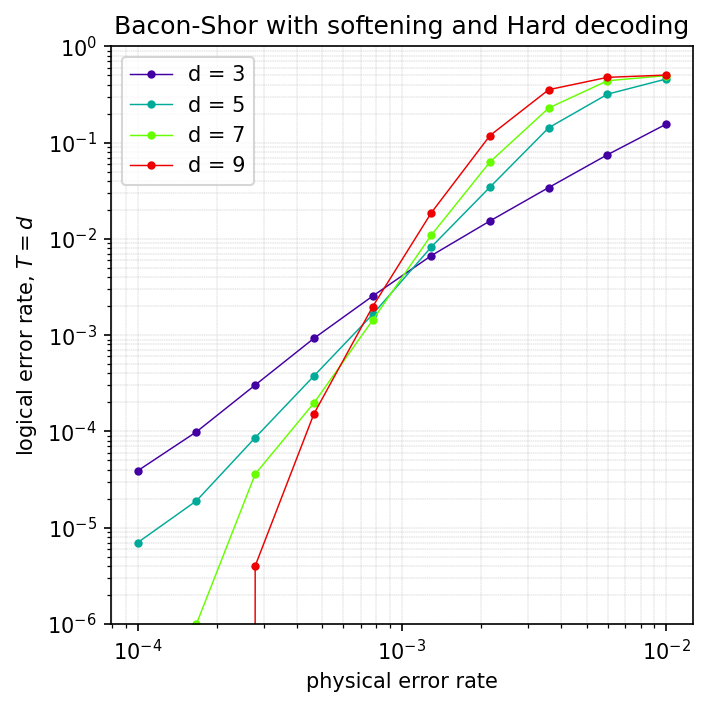

In [70]:
from matplotlib import colormaps
import matplotlib.pyplot as plt

color_list = [colormaps.get_cmap('nipy_spectral')((i+0.5)/len(dist_list)) for i in range(len(dist_list))]


fig=plt.figure(figsize=(5, 5), dpi=150)

for di,d in enumerate(dist_list):
    phys_err, log_err, _ = np.transpose(Log_fail_d_p_hard[di][1])
    plt.plot(phys_err, log_err,'.-', c=color_list[di],linewidth = 0.7, label = 'd = '+str(d))



# pth,pLatth = 1e-3, 0.0025
pth, pLatth = 8e-4, 0.0015

# for di,d in enumerate(dist_list):
#     phys_err, log_err, log_err_err = np.transpose(Log_fail_d_p[di][1])
#     log_err_err = np.array(log_err_err, dtype=float)
#     log_err = np.array(log_err, dtype=float)
#     phys_err = np.array(phys_err, dtype=float)
#     plt.fill_between(phys_err, log_err-log_err_err, log_err+log_err_err,alpha = 0.13,color=color_list[di]) 
#     plt.plot(error_list, pLatth*(error_list/pth)**np.ceil((d+1)/2),'--',c='gray', alpha=0.5)

# plt.axvline(pth,linestyle=':',c="gray", alpha=0.3, label = f'$p_th = {pth:.1e}$')
# plt.legend(['d = '+str(d) for d in dist_list])
plt.legend()

plt.title(f"Bacon-Shor with softening and Hard decoding")
plt.xlabel(r'physical error rate')
plt.ylabel(r'logical error rate, $T = d$')
plt.ylim(1e-6,1)
plt.loglog()
plt.grid(which='both', linestyle='--', linewidth=0.2)
# plt.savefig(home+'/figures/threshold_plot_dT3to9_BSonly_nops.pdf',bbox_inches = 'tight')
plt.show()